In [ ]:
# Data
import pandas as pd
import numpy as np

# Sklearn
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.transformers

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# TensorFlow
import tensorflow as tf

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TFDistilBertForSequenceClassification,
    DistilBertTokenizerFast
)

# Hugging Face datasets
from datasets import Dataset

# Progress bar
from tqdm import tqdm


e:\Formation - Copie\Projets\AnalyseSentiments\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
columns_to_keep = ["text_bert", "target"]

data = pd.read_csv(
    "data/tweets_cleaned.csv",
    usecols=columns_to_keep,
    encoding="latin-1"
)


In [ ]:
# Preview the dataset
print(data.head())
print(data["target"].unique())

# Ensure target is integer type
data["target"] = data["target"].astype(int)
print(data.dtypes)

# Define size of the new dataset
subset_size = 100_000

# Compute class ratios
class_ratios = data["target"].value_counts(normalize=True)

# Determine number of samples to keep per class
samples_per_class = (class_ratios * subset_size).astype(int)

# Perform stratified sampling
data = pd.concat([
    data[data["target"] == 0].sample(n=samples_per_class[0], random_state=42),
    data[data["target"] == 1].sample(n=samples_per_class[1], random_state=42)
])

# Check resulting distribution
print(data["target"].value_counts())


[0 1]
target        int32
text_bert    object
dtype: object


target
0    50000
1    50000
Name: count, dtype: int64

In [ ]:
# Define split proportions (70% Train, 15% Validation, 15% Test)
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Separate features and target
X = data[["text_bert"]]
y = data["target"]

# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=(1 - train_size), stratify=y, random_state=42
)

# Second split: Validation (15%) and Test (15%) from Temp (30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=test_size / (test_size + val_size),
    stratify=y_temp,
    random_state=42
)

# Display data distribution
print("Data distribution after split:")
print(f"Train: {len(X_train)} ({y_train.value_counts(normalize=True)})")
print(f"Validation: {len(X_val)} ({y_val.value_counts(normalize=True)})")
print(f"Test: {len(X_test)} ({y_test.value_counts(normalize=True)})")


Répartition des données après découpage :
Train : 69999 (target
1    0.500007
0    0.499993
Name: proportion, dtype: float64)
Validation : 15000 (target
1    0.5
0    0.5
Name: proportion, dtype: float64)
Test : 15001 (target
0    0.500033
1    0.499967
Name: proportion, dtype: float64)


In [ ]:
# Configuration
model_name = "distilbert-base-uncased"
batch_size = 16
epochs = 3
learning_rate = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add <OOV> token if missing
if "<OOV>" not in tokenizer.get_vocab():
    tokenizer.add_tokens(["<OOV>"])

# Load classification model and resize embeddings
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2
).to(device)
model.resize_token_embeddings(len(tokenizer))

# Custom Dataset class for tokenized input
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts, truncation=True, padding=True, return_tensors="pt"
        )
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create train, validation, and test datasets
train_dataset = TextDataset(X_train["text_bert"].tolist(), y_train.tolist())
val_dataset = TextDataset(X_val["text_bert"].tolist(), y_val.tolist())
test_dataset = TextDataset(X_test["text_bert"].tolist(), y_test.tolist())

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# Training and logging with MLflow
mlflow.set_experiment("DISTILBERT_MODEL_FULLY_TRAINED")

with mlflow.start_run():
    mlflow.log_params({
        "model": model_name,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} finished - Average loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels)

    # Compute all metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    loss = log_loss(all_labels, all_probs)
    baseline_acc = pd.Series(all_labels).value_counts(normalize=True).max()
    confidence_std = np.std(all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    false_positives = cm[0][1]
    false_negatives = cm[1][0]

    # Log metrics to MLflow
    mlflow.log_metrics({
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "log_loss": loss,
        "baseline_accuracy": baseline_acc,
        "confidence_std": confidence_std,
        "false_positives": false_positives,
        "false_negatives": false_negatives
    })

    print(f"Accuracy: {accuracy:.4f} | F1: {f1:.4f} | ROC AUC: {roc_auc:.4f}")

    # Save model weights (PyTorch)
    torch.save(model.state_dict(), "DISTILBERT_MODEL_FULLY_TRAINED.pt")
    mlflow.log_artifact("DISTILBERT_MODEL_FULLY_TRAINED.pt")

    # Save full model (architecture + weights) and tokenizer
    save_path = "DISTILBERT_MODEL_FULL"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)


Epoch 1/3: 100%|██████████| 4375/4375 [7:35:19<00:00,  6.24s/it]  


Époque 1 terminée - perte moyenne : 0.4156


Epoch 2/3: 100%|██████████| 4375/4375 [7:34:38<00:00,  6.24s/it]  


Époque 2 terminée - perte moyenne : 0.3088


Epoch 3/3: 100%|██████████| 4375/4375 [7:34:49<00:00,  6.24s/it]  


Époque 3 terminée - perte moyenne : 0.2030
 Accuracy: 0.8199, F1 Score: 0.8159, ROC AUC: 0.9028


('DISTILBERT_MODEL_FULL\\tokenizer_config.json',
 'DISTILBERT_MODEL_FULL\\special_tokens_map.json',
 'DISTILBERT_MODEL_FULL\\vocab.txt',
 'DISTILBERT_MODEL_FULL\\added_tokens.json',
 'DISTILBERT_MODEL_FULL\\tokenizer.json')

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast

# Load model from Hugging Face directory (converted from PyTorch to TF)
save_path = "DISTILBERT_MODEL_FULL"
model = TFDistilBertForSequenceClassification.from_pretrained(save_path, from_pt=True)

# Wrapper to define explicit TFLite input signature
class TFLiteWrapper(tf.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    @tf.function(input_signature=[
        tf.TensorSpec([None, 128], tf.int32, name="input_ids"),
        tf.TensorSpec([None, 128], tf.int32, name="attention_mask")
    ])
    def __call__(self, input_ids, attention_mask):
        outputs = self.model({'input_ids': input_ids, 'attention_mask': attention_mask})
        return {"logits": outputs.logits}

# Wrap and export the model to SavedModel format
wrapped = TFLiteWrapper(model)
saved_model_dir = "TMP_TF_SAVED_MODEL"
tf.saved_model.save(
    wrapped,
    saved_model_dir,
    signatures=wrapped.__call__.get_concrete_function()
)

# Convert the SavedModel to TFLite format with default optimizations
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to file
with open("distilbert_model.tflite", "wb") as f:
    f.write(tflite_model)

# Save the tokenizer to use with TFLite inference
tokenizer = DistilBertTokenizerFast.from_pretrained(save_path)
tokenizer.save_pretrained("DISTILBERT_MODEL_TFLITE")


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:Assets written to: TMP_TF_SAVED_MODEL\assets


INFO:tensorflow:Assets written to: TMP_TF_SAVED_MODEL\assets


('DISTILBERT_MODEL_TFLITE\\tokenizer_config.json',
 'DISTILBERT_MODEL_TFLITE\\special_tokens_map.json',
 'DISTILBERT_MODEL_TFLITE\\vocab.txt',
 'DISTILBERT_MODEL_TFLITE\\added_tokens.json',
 'DISTILBERT_MODEL_TFLITE\\tokenizer.json')

In [ ]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    """
    Display confusion matrix using Seaborn.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_test, y_prob, model_name):
    """
    Display ROC curve using Seaborn lineplot.
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    sns.lineplot(x=fpr, y=tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_bar_chart(model_scores, title):
    """
    Display bar chart comparing model metrics.
    """
    labels, accuracy, f1, roc_auc = zip(*model_scores)

    df = pd.DataFrame({
        "Model": labels,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })

    df_melt = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_melt, x="Model", y="Score", hue="Metric")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_boxplot(roc_auc_scores, title):
    """
    Display ROC AUC score distribution using a boxplot.
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=roc_auc_scores)
    plt.title(title)
    plt.ylabel("ROC AUC Score")
    plt.tight_layout()
    plt.show()


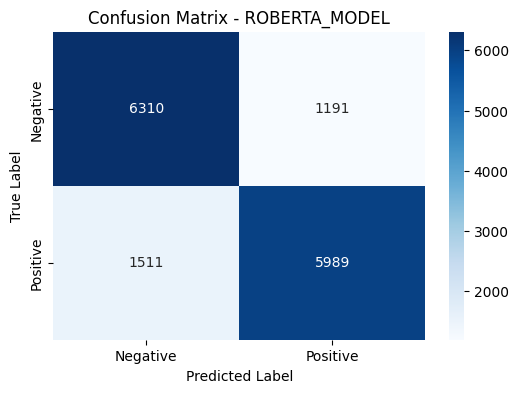

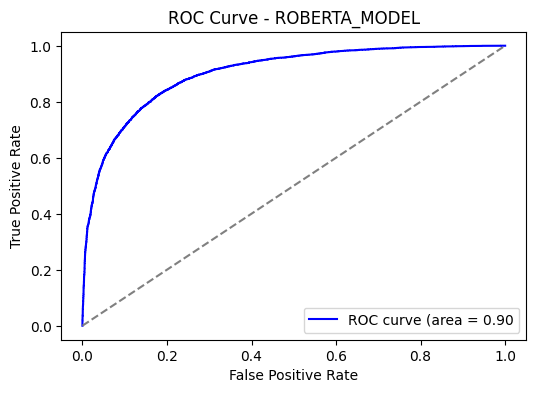

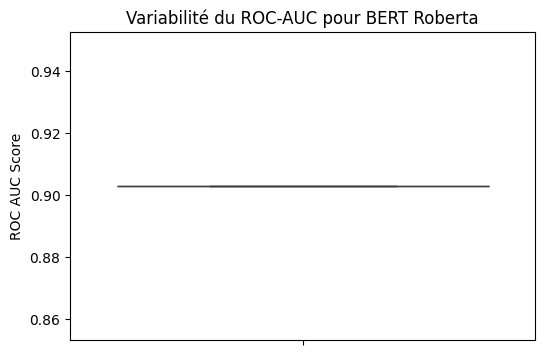

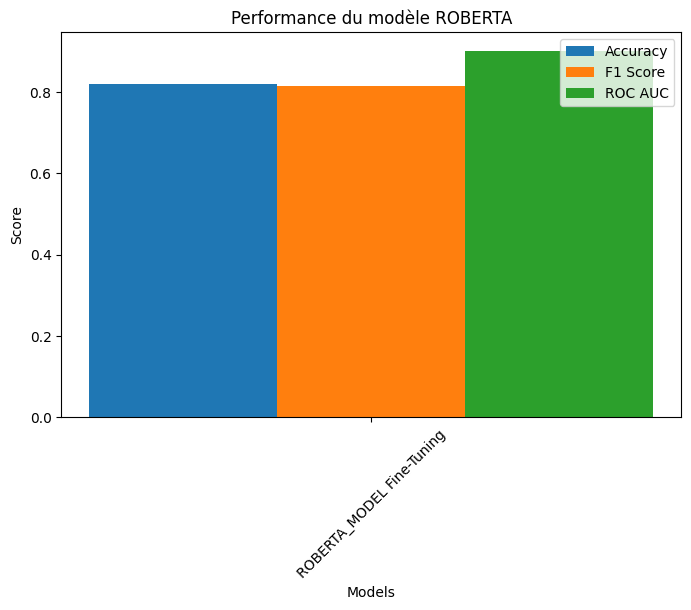

In [ ]:
# Display visualizations using Seaborn only 
plot_confusion_matrix(all_labels, all_preds, model_name="ROBERTA_MODEL")
plot_roc_curve(all_labels, all_probs, model_name="ROBERTA_MODEL")
plot_boxplot([roc_auc], title="ROC-AUC Variability - ROBERTA_MODEL")
plot_bar_chart(
    [("ROBERTA_MODEL Fine-Tuning", accuracy, f1, roc_auc)],
    title="ROBERTA_MODEL Performance Comparison"
)

mlflow.end_run()